# Chemical-Image2SMILES
#### Method
: Image => Skeleton => Graph => Mol => SMILES

## Problems
Skeleton => Graph

- Difficult to make nodes to vertices from skeleton
- Difficult to know what symbols of atoms from nodes are
- Difficult to recognize other than single bonds

#### Therefore, I just only suggest an idea with a simple example.

In [1]:
import PIL.Image as pilimg
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import color
import sknw
import warnings
from rdkit import Chem
warnings.filterwarnings('ignore')

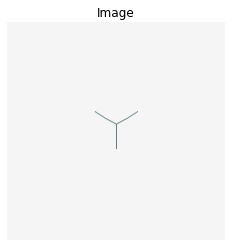

In [2]:
# open and skeletonize
img = pilimg.open('Isobutane_300.png')
plt.title('Image')
plt.axis('off')
plt.imshow(img, cmap='gray')

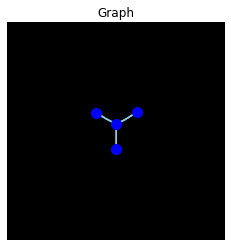

In [3]:
# open and skeletonize
img = pilimg.open('Isobutane_300.png')

img = np.array(img)
img = np.where(img>np.mean(img),1.0,0.0)
img = color.rgb2gray(img)
ske = skeletonize(img).astype(np.uint16)

# build graph from skeleton
graph = sknw.build_sknw(ske)

# draw image
plt.imshow(img, cmap='gray')

for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'skyblue')
    
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.', markersize=20, c='blue')

# title and show
plt.axis('off')
plt.title('Graph')
plt.show()

In [4]:
# Nodes (Carbon)
graph.nodes

NodeView((0, 1, 2, 3))

In [5]:
# Edge
graph.edges

EdgeView([(0, 2), (1, 2), (2, 3)])

In [6]:
# Adjacency
size = len(set([n for e in graph.edges for n in e])) 
adjacency = [[0]*size for _ in range(size)]
for sink, source in graph.edges:
    adjacency[int(sink)][int(source)] = 1
    adjacency[int(source)][int(sink)] = 1

adjacency = np.array(adjacency) + np.eye(size)
adjacency

array([[1., 0., 1., 0.],
       [0., 1., 1., 0.],
       [1., 1., 1., 1.],
       [0., 0., 1., 1.]])

In [7]:
def MolFromGraphs(node_list, adjacency_matrix):

    # create empty editable mol object
    mol = Chem.RWMol()

    # add atoms to mol and keep track of index
    node_to_idx = {}
    for i in range(len(node_list)):
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    # add bonds between adjacent atoms
    for ix, row in enumerate(adjacency_matrix):
        for iy, bond in enumerate(row):

            # only traverse half the matrix
            if iy <= ix:
                continue

            # add relevant bond type (there are many more of these)
            if bond == 0:
                continue
            elif bond == 1:
                bond_type = Chem.rdchem.BondType.SINGLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            elif bond == 2:
                bond_type = Chem.rdchem.BondType.DOUBLE
                mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

    # Convert RWMol to Mol object
    mol = mol.GetMol()            

    return mol

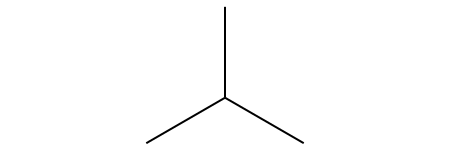

In [8]:
mol = MolFromGraphs(['C' for i in range(size)], adjacency)
mol

In [9]:
Chem.MolToSmiles(mol)

'CC(C)C'